## This is a Python analysis of RideAustin's daily ride requests, identifying a weekly cycle in requests, and using that cycle to predict weekly growth using an exponential curve fit

Data was made available by CEO Andy Tryba, at https://data.world/andytryba/rideaustin

Ride Austin is a nonprofit, municipal ridesharing service based in Austin, Texas, with a model comparing directly to that of Uber. The data released covers rides requested from June 16 to August 31, just over 11 weeks. It shows a clear cycle weekly, typically with peak ride demand on Saturday. 

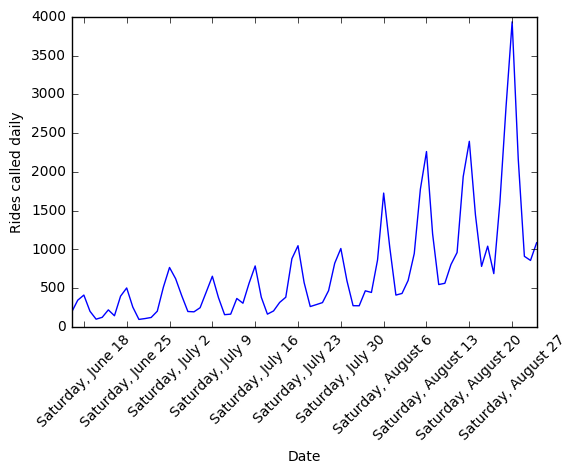

In [194]:
#loading the dataset
from pandas import Series
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

RideVolume = Series.from_csv('RideVolume.csv', header=0)
RideVolume.plot(xticks=(range(2,78,7))) # this xticks arg labels the Saturdays
plt.xticks(rotation=45) 
plt.ylabel('Rides called daily')
plt.show()
plt.close()

Plainly, the plot shows a regular weekly spike; count and you see 11 spikes, corresponding to the 11+ weeks in the data set. We also see a dramatic growth in this time, a 10-fold expansion from the first to the last Saturday in the series. Though it's less obvious, the less popular days (Monday and Tuesday) also show a roughly 10x expansion across this time. 

To model this as a curve-fit directly from the data points will be difficult, because there is a large difference between the days of the week. So, I'm going to separate the data points available into the different specific days of the week, and perform a polynomial growth curve fit on these series, then interpolate the curve of best fit projections into the data. This treats each day of the week as having a separate growth curve.

It seems most likely that this curve will, in real life, become sigmoidal, as RideAustin approaches market saturation. This model is then only useful for short-term predictions.

This code is adapted in part from Leandro's answer, here:
http://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly

### Modeling the days of the week as separate exponential curves

In [195]:
# Separating the CSV into a series for each weekday. It would be easy to 
# define this as a function or class, accepting as parameters a first-
# number offset and the range end as len(RideVolume)
Mondays=RideVolume.iloc[range(4,77,7)]
Tuesdays=RideVolume.iloc[range(5,77,7)]
Wednesdays=RideVolume.iloc[range(6,77,7)]
Thursdays=RideVolume.iloc[range(0,77,7)] 
Fridays=RideVolume.iloc[range(1,77,7)]
Saturdays=RideVolume.iloc[range(2,77,7)]
Sundays=RideVolume.iloc[range(3,77,7)]

print(Mondays)
#print(Tuesdays)
#print(Wednesdays)
#print(Thursdays)
#print(Fridays)
#print(Saturdays)
#print(Sundays)

Date
Monday, June 20      100
Monday, June 27       97
Monday, July 4       402
Monday, July 11      158
Monday, July 18      165
Monday, July 25      263
Monday, August 1     274
Monday, August 8     411
Monday, August 15    547
Monday, August 22    781
Monday, August 29    911
Name: Rides, dtype: int64


In [196]:
#Now we can find a curve which fits to the Saturdays specifically
#Adapted from http://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy
import sympy

# The following creates arrays of data points from the Series objects from earlier. These will be used 
# to perform the curve fit for each set.
SatRides=numpy.array(Saturdays[:], dtype=float)
SunRides=numpy.array(Sundays[:], dtype=float)
MonRides=numpy.array(Mondays[:], dtype=float)
TueRides=numpy.array(Tuesdays[:], dtype=float)
WedRides=numpy.array(Wednesdays[:], dtype=float)
ThuRides=numpy.array(Thursdays[:], dtype=float)
FriRides=numpy.array(Fridays[:], dtype=float)
print('FriRides =',FriRides)
# We can model it using the curve-fit for the data presented as weekly events, which we'll call 'weekly'
# below, but in order to superimpose the function onto the plot we'll need to be able to graph the 
# resulting curve against the days, so we can use both.
weekly=numpy.array(range(1,12,1), dtype=float)

# Below is a polynomial function with unknown coefficient and unknown y-intercept
def func(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d
# we're going to use scipy's curve_fit to optimize for it
#this may throw a libMKL error unless you're using numpy 11.1.13+
poptSat, pcovSat = curve_fit(func,weekly,SatRides) # x is the 'weekly' array, y is 'SatRides'
poptMon, pcovMon = curve_fit(func,weekly,MonRides)

def SatFunc(x):
    return poptSat[0]*x**3 +poptSat[1]*x**2 + poptSat[2]*x + poptSat[3]
def MonFunc(x):
    return poptMon[0]*x**3 +poptMon[1]*x**2 + poptMon[2]*x + poptMon[3]

FriRides = [  345.   397.   514.   450.   563.   880.   822.   864.  1777.  1939.
  2839.]


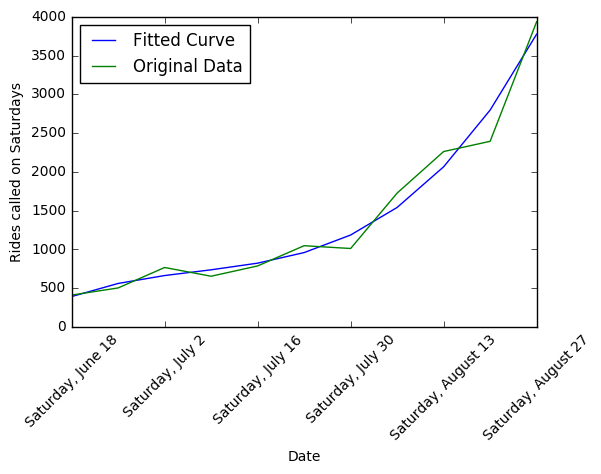

In [197]:
# First overlay the Saturday curve on the original Saturday data.

plt.plot(SatFunc(weekly), label='Fitted Curve')
Saturdays.plot(label="Original Data")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called on Saturdays')
plt.show()
plt.close()

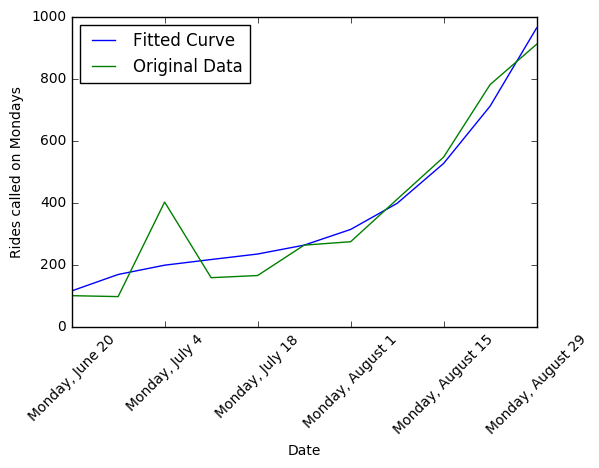

In [198]:
# Then overlay the Monday curve over the Monday original data.

plt.plot(MonFunc(weekly), label='Fitted Curve')
Mondays.plot(label="Original Data")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called on Mondays')
plt.show()
plt.close()

These polynomial models seem to fit pretty well. Now we adapt them to daily coefficients, and interweave them into the final model.

### Daily models and composite model

In [224]:
# The following date-specific lists give the location in the original RideVolume 
# series object to which each prediction corresponds. 
MonDateLoc=list(range(4,77,7))
TueDateLoc=list(range(5,77,7))
WedDateLoc=list(range(6,77,7))
ThuDateLoc=list(range(0,77,7))
FriDateLoc=list(range(1,77,7))
SatDateLoc=list(range(2,77,7))
SunDateLoc=list(range(3,77,7))

# The following generates regression coefficients fitted to these dates
poptSat, pcovSat = curve_fit(func,SatDateLoc,SatRides) # x is the 'weekly' array, y is 'SatRides'
poptSun, pcovSun = curve_fit(func,SunDateLoc,SunRides)
poptMon, pcovMon = curve_fit(func,MonDateLoc,MonRides)
poptTue, pcovTue = curve_fit(func,TueDateLoc,TueRides)
poptWed, pcovWed = curve_fit(func,WedDateLoc,WedRides)
poptThu, pcovThu = curve_fit(func,ThuDateLoc,ThuRides)
poptFri, pcovFri = curve_fit(func,FriDateLoc,FriRides)

# The following defines functions for these coefficients
def SatFund(x):
    return poptSat[0]*x**3 +poptSat[1]*x**2 + poptSat[2]*x + poptSat[3]
def SunFund(x):
    return poptSun[0]*x**3 +poptSun[1]*x**2 + poptSun[2]*x + poptSun[3]
def MonFund(x):
    return poptMon[0]*x**3 +poptMon[1]*x**2 + poptMon[2]*x + poptMon[3]
def TueFund(x):
    return poptTue[0]*x**3 +poptTue[1]*x**2 + poptTue[2]*x + poptTue[3]
def WedFund(x):
    return poptWed[0]*x**3 +poptWed[1]*x**2 + poptWed[2]*x + poptWed[3]
def ThuFund(x):
    return poptThu[0]*x**3 +poptThu[1]*x**2 + poptThu[2]*x + poptThu[3]
def FriFund(x):
    return poptFri[0]*x**3 +poptFri[1]*x**2 + poptFri[2]*x + poptFri[3]

# The following weaves the predictions for the best fit functions into a daily series
modellist = []
for x in range(0,77):
    if x in MonDateLoc:
        modellist.append(MonFund(x))
    elif x in TueDateLoc:
        modellist.append(TueFund(x))
    elif x in WedDateLoc:
        modellist.append(WedFund(x))
    elif x in ThuDateLoc:
        modellist.append(ThuFund(x))
    elif x in FriDateLoc:
        modellist.append(FriFund(x))
    elif x in SatDateLoc:
        modellist.append(SatFund(x))
    elif x in SunDateLoc:
        modellist.append(SunFund(x))

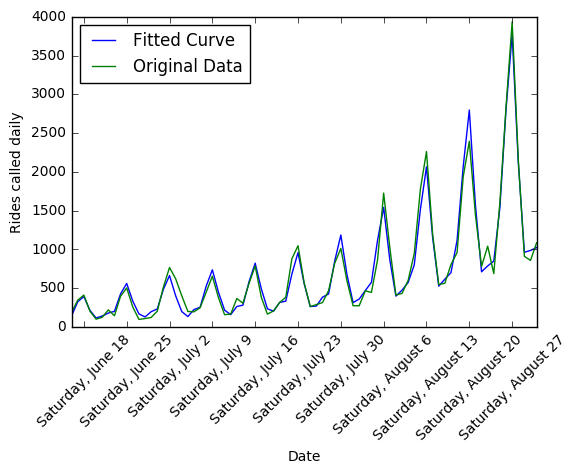

In [225]:
plt.plot(modellist, label='Fitted Curve')
RideVolume.plot(xticks=(range(2,78,7)), label = 'Original Data')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called daily')
plt.show()
plt.close()

As we can see, the composite polynomial model fits the data quite closely. It can of course be extrapolated to predict future developments outside of this data:

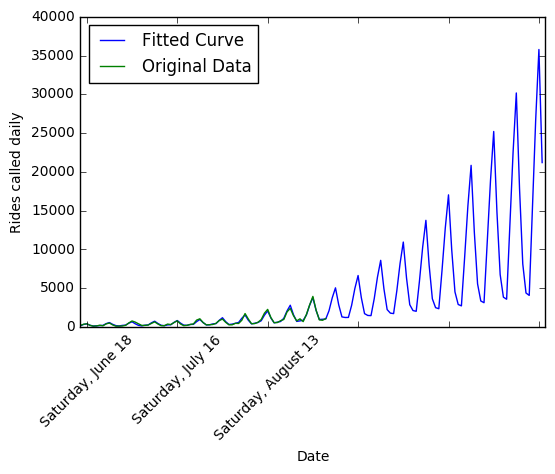

In [230]:
MonDateLocX=list(range(4,144,7))
TueDateLocX=list(range(5,144,7))
WedDateLocX=list(range(6,144,7))
ThuDateLocX=list(range(0,144,7))
FriDateLocX=list(range(1,144,7))
SatDateLocX=list(range(2,144,7))
SunDateLocX=list(range(3,144,7))

modellistX = []
for x in range(0,144):
    if x in MonDateLocX:
        modellistX.append(MonFund(x))
    elif x in TueDateLocX:
        modellistX.append(TueFund(x))
    elif x in WedDateLocX:
        modellistX.append(WedFund(x))
    elif x in ThuDateLocX:
        modellistX.append(ThuFund(x))
    elif x in FriDateLocX:
        modellistX.append(FriFund(x))
    elif x in SatDateLocX:
        modellistX.append(SatFund(x))
    elif x in SunDateLocX:
        modellistX.append(SunFund(x))


plt.plot(modellistX, label='Fitted Curve')
RideVolume.plot(xticks=(range(2,144,28)), label = 'Original Data')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called daily')
plt.xlim(0,144)
plt.show()
plt.close()

Of course, the real model should be a sigmoid curve which flattens as we approach market saturation, yet that upper boundary itself should be modelable as we activate new local markets. This model will necessarily depart from the actual data at some time; the time of its departure will show us where on the sigmoid curve we are, from which we can infer/quantify present market activation.